# **Sentiment Analysis for IMDb movies 🍿👀📽**

In this project, I perform sentiment analysis on IMDb movies' reviews.I classify the reviews into two classes (Positive and Negative) by fine-tuning the pretrained **BERT-base model** experimenting with several parameters.



 We install the Hugging Face transformers library 

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 55.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 13.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split



## **Load the dataset** 

For **testing** the model give to **TESTING_DATA_PATH** variable the path where the file with testing data is located

In [ ]:
TESTING_DATA_PATH=""
DATA_PATH=""

In [ ]:
if not DATA_PATH:
  drive.mount('/content/drive')
  DATA_PATH = "/content/drive/MyDrive/AI_2_exercise_1_data/imdb-reviews.csv"
df = pd.read_csv(filepath_or_buffer=DATA_PATH, sep='\t')

if TESTING_DATA_PATH:
  # test_df = df.copy()
  # test_df = test_df.iloc[36006:45009]
  test_df = pd.read_csv(file_or_buffer=TESTING_DATA_PATH, sep='\t')

Mounted at /content/drive


A look at our data

In [ ]:
if not TESTING_DATA_PATH:
  print(f"Dataset shape: {df.shape}")
  pd.set_option('display.max_colwidth', 1000)
  df.head()

Dataset shape: (45008, 3)


Convert the sentiments as following:

* POS → 0
* NEG → 1

In [ ]:
df['rating'] = df['rating'].astype('int')
if TESTING_DATA_PATH:
  test_df['rating'] = test_df['rating'].astype('int')

In [ ]:
 df.loc[df['rating'] < 5, ['rating']] = 0
 df.loc[df['rating'] > 6, ['rating']] = 1
 if TESTING_DATA_PATH:
   test_df.loc[test_df['rating'] < 5, ['rating']] = 0
   test_df.loc[test_df['rating'] > 6, ['rating']] = 1

## **Data pre-processing**

### **Text Transformation**

In [ ]:
df.drop('url', inplace=True, axis=1)
if TESTING_DATA_PATH:
  test_df.drop('url', inplace=True, axis=1)

In [ ]:
if not TESTING_DATA_PATH:
  print(df.isnull().sum())

rating    0
review    0
dtype: int64


We detect no missing values in the dataset

In [ ]:
import re
import string
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

# Define the function for text transformation
def text_transformation(text):
  # Lower characters
  text = text.lower()
  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text)
  # Remove links
  text = re.sub('http://\S+|https://\S+', '', text)
  #Removing html tags
  html=re.compile(r'<.*?>')   
  text = html.sub(r'',text) 
  # Remove punctuation
  text = text.translate(str.maketrans('', '', string.punctuation))
  # Remove stopwords
  StopWords = stopwords.words("english")
  text = ' '.join([word for word in text.split() if word not in StopWords])
  # Remove emojis
  emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  
                           u"\U0001F300-\U0001F5FF"  
                           u"\U0001F680-\U0001F6FF" 
                           u"\U0001F1E0-\U0001F1FF" 
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
  text = emoji_pattern.sub(r'', text) 
  
  return text  

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df['review'] = df['review'].apply(text_transformation)
if TESTING_DATA_PATH:
  test_df['review'] = test_df['review'].apply(text_transformation)


In [ ]:
df.head()

,rating,review
0,1,thought quiet good movie fun watch liked best outtakes end movie great
1,1,wagon master unique film amongst john ford work mainly one based story written john ford story elaborated frank nugent director son patrick ford turned screenplay director personal opinion regarding wagon master film john ford called one came closest wanted achieve say say little ford confessed lindsay anderson favourite nonetheless darling clementine br br wagon master ingredients one might expect find john ford film wonderful cast delivering best thou featuring major stars except fordian actors ben johnson peculiar small characters provide obligatory comic relief wagon master quite horn blowing sister ledyard jane darwell shot inspired gigs last least legendary monument valley john ford fifth passage stagecoach darling clementine fort apache wore yellow ribbon br br film starts two friends cowboys travis blue ben johnson sandy owens harry carey jr hired wagon masters guides caravan mormon settlers headed silver valley place like promised land way joined peculiar dr locksley hall ...
2,1,film near perfect film john ford made film magic masterpiece reason ford well ford want know ford great one explains br br photography course superb black white black white wonderful shots shoulder conversation pure ford great moments big little famous ripped pants ward bond apparently two dogs kept invading set fighting ford wanted use fighting scene instead fighting one dog ran away attacked ward bond ripped pants caused ford end mirth whole scene around plaiting rope way ben johnson burn snuffs rope wonderful foreshadowing anticipation final harry carey naive courting prudence usual ford line scared showing bond horse accidentally falling left film johnson bond fantastic scene lord help ford actor stay character camera rolling even horse falls top br br couple sweet romances intruding whole focus two likable leads mention girls number times cameras focus ben johnson rather delightful backside br br lots old time stuntmen getting lines roles cliff lyons frank mcgrath wonderful ch...
3,0,gave stars lot interesting themes many already mentioned domestic violence sexuality many taboos therein outside gore really would call horror much would science fiction br br bleak depressing hopeless mind less cheery ending really tired humans suck clich central every movie know get liberal arts degree today without bowing alter self hatred member human race bout writer director pretend different everyone else pack notice aliens killing human race evil right reading believe humanity deserves die go find lake swim til arms tired way around direct next film write next book telling deserve die alive silly thoughtful boring
4,1,movie really genuine random really hard find movies like bunches movies hollywood really enjoy watching movie bought dvd tuesday week watched times love spanglish accent paz really cute acting morgan funny natural br br movie taste might really different others say really love movie simple best br br learned something life movie well least usa life life really random sometimes u meet someone pass life friends coincidently u spend much time maybe u enjoy u never meet time u together really unforgettable keep moments mind grateful nice memories br br movie might cheap making price meanings totally cheap rarely learn anything movies exception


### Using BertTokenizer

In [ ]:
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case = True
    )

In [ ]:
reviews = df.review.values
ratings = df.rating.values
if TESTING_DATA_PATH:
  test_reviews = test_df.review.values
  test_ratings = test_df.rating.values

Split the first review into word-level tokens and map them to their respective IDs in the BERT vocabulary

In [ ]:
from tabulate import tabulate

table = np.array([tokenizer.tokenize(reviews[0]), 
                    tokenizer.convert_tokens_to_ids(tokenizer.tokenize(reviews[0]))]).T
print(tabulate(table,
                headers = ['Tokens', 'Token IDs'],
                tablefmt = 'fancy_grid'))

╒══════════╤═════════════╕
│ Tokens   │   Token IDs │
╞══════════╪═════════════╡
│ thought  │        2245 │
├──────────┼─────────────┤
│ quiet    │        4251 │
├──────────┼─────────────┤
│ good     │        2204 │
├──────────┼─────────────┤
│ movie    │        3185 │
├──────────┼─────────────┤
│ fun      │        4569 │
├──────────┼─────────────┤
│ watch    │        3422 │
├──────────┼─────────────┤
│ liked    │        4669 │
├──────────┼─────────────┤
│ best     │        2190 │
├──────────┼─────────────┤
│ outta    │       24955 │
├──────────┼─────────────┤
│ ##kes    │        9681 │
├──────────┼─────────────┤
│ end      │        2203 │
├──────────┼─────────────┤
│ movie    │        3185 │
├──────────┼─────────────┤
│ great    │        2307 │
╘══════════╧═════════════╛


Bert requires to:
1. Add [CLS] at the beginning of each sentence (ID 101) and [SEP] at the end of each sentence (ID 102)
2. Make sentences of the same length
3. Create an attention mask

encode_plus method returns a transformers.tokenization.tokenization-utils_base.BatchEncoding object with the following fields:

* **input_ids**: list of token IDs.
* **token_type_ids**: list of token type IDs.
* **attention_mask**: list of 0/1 indicating which tokens should be considered by the model (return_attention_mask = True).

Sentences that exceed max_length will be truncated, while shorter sentences will be populated with [PAD] tokens (id: 0) until they reach the desired length.

In [ ]:
tokens_ids = []
attention_masks = []

for review in reviews:
  encoding_dict = tokenizer.encode_plus(
                        review,
                        add_special_tokens = True,
                        max_length = 64,
                        padding = 'max_length',
                        truncation = True,
                        return_attention_mask = True,
                        return_tensors = 'pt'
                  )
  
  tokens_ids.append(encoding_dict['input_ids']) 
  attention_masks.append(encoding_dict['attention_mask'])

In [ ]:
if TESTING_DATA_PATH:
  test_tokens_ids = []
  test_attention_masks = []

  for test_review in test_reviews:
    test_encoding_dict = tokenizer.encode_plus(
                          test_review,
                          add_special_tokens = True,
                          max_length = 64,
                          padding = 'max_length',
                          truncation = True,
                          return_attention_mask = True,
                          return_tensors = 'pt'
                    )
    
    test_tokens_ids.append(test_encoding_dict['input_ids']) 
    test_attention_masks.append(test_encoding_dict['attention_mask'])

In [ ]:
#Convert the lists into tensors
tokens_ids = torch.cat(tokens_ids, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
ratings = torch.tensor(ratings)

In [ ]:
if TESTING_DATA_PATH:
  #Convert the lists into tensors
  test_tokens_ids = torch.cat(test_tokens_ids, dim = 0)
  test_attention_masks = torch.cat(test_attention_masks, dim = 0)
  test_ratings = torch.tensor(test_ratings)

Tokens, IDs and the attention mask for the first sentence 

In [ ]:
tokens_instance = tokenizer.tokenize(tokenizer.decode(tokens_ids[0]))
token_ids_instance = [i.numpy() for i in tokens_ids[0]]
attention_instance = [i.numpy() for i in attention_masks[0]]

table = np.array([tokens_instance, token_ids_instance, attention_instance]).T
print(tabulate(table, headers = ['Tokens', 'Token IDs', 'Attention Mask'], tablefmt = 'fancy_grid'))


╒══════════╤═════════════╤══════════════════╕
│ Tokens   │   Token IDs │   Attention Mask │
╞══════════╪═════════════╪══════════════════╡
│ [CLS]    │         101 │                1 │
├──────────┼─────────────┼──────────────────┤
│ thought  │        2245 │                1 │
├──────────┼─────────────┼──────────────────┤
│ quiet    │        4251 │                1 │
├──────────┼─────────────┼──────────────────┤
│ good     │        2204 │                1 │
├──────────┼─────────────┼──────────────────┤
│ movie    │        3185 │                1 │
├──────────┼─────────────┼──────────────────┤
│ fun      │        4569 │                1 │
├──────────┼─────────────┼──────────────────┤
│ watch    │        3422 │                1 │
├──────────┼─────────────┼──────────────────┤
│ liked    │        4669 │                1 │
├──────────┼─────────────┼──────────────────┤
│ best     │        2190 │                1 │
├──────────┼─────────────┼──────────────────┤
│ outta    │       24955 │        

### **Train Test split**

Split dataset

In [ ]:
train_idx, test_idx = train_test_split(np.arange(len(ratings)), test_size = 0.2,random_state=42)

if not TESTING_DATA_PATH:
  train_idx, val_idx = train_test_split(train_idx, test_size=0.2, random_state=42)
  val_set = TensorDataset(tokens_ids[val_idx], 
                          attention_masks[val_idx], 
                          ratings[val_idx])

train_set = TensorDataset(tokens_ids[train_idx], 
                          attention_masks[train_idx], 
                          ratings[train_idx])
if not TESTING_DATA_PATH:
  test_set = TensorDataset(tokens_ids[test_idx], 
                           attention_masks[test_idx], 
                           ratings[test_idx])
else:
  test_set = TensorDataset(test_tokens_ids,
                           test_attention_masks,
                           test_ratings)

In [ ]:
# Returns train_dataloader, test_dataloader if val_set = None
# otherwise returns  train_dataloader, test_dataloader, val_dataloader
def get_dataloaders(batch_size, train_set, test_set, val_set=None):
  train_dataloader = DataLoader(train_set,
                              sampler = RandomSampler(train_set),
                              batch_size = batch_size)

  test_dataloader = DataLoader(test_set,
                              sampler = SequentialSampler(test_set),
                              batch_size = batch_size)
  if val_set != None:
    val_dataloader = DataLoader(val_set,
                                     sampler = SequentialSampler(val_set),
                                     batch_size = batch_size)
    return train_dataloader, test_dataloader, val_dataloader
    
  return train_dataloader, test_dataloader

## Training-Evaluating-Experimening

In [ ]:
def plot_loss_acc(train_losses, val_losses, train_accuracies, val_accuracies, n_epochs, append_to_title=""):
  plt.style.use("ggplot")
  plt.figure(figsize=(12, 8))

  plt.plot(np.arange(0, n_epochs), train_losses, label="train_loss")
  plt.plot(np.arange(0, n_epochs), val_losses, label="val_loss")
  plt.plot(np.arange(0, n_epochs), train_accuracies, label="train_acc")
  plt.plot(np.arange(0, n_epochs), val_accuracies, label="val_acc")
  plt.title("Training Loss and Accuracy" + append_to_title)
  plt.xlabel("Epoch")
  plt.ylabel("Loss/Accuracy")
  plt.legend()

In [ ]:
def b_tp(preds, labels):
  return sum([preds == labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_fp(preds, labels):
  return sum([preds != labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_tn(preds, labels):
  return sum([preds == labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_fn(preds, labels):
  return sum([preds != labels and preds == 0 for preds, labels in zip(preds, labels)])

def get_accuracy(preds, labels):
  preds = np.argmax(preds, axis = 1).flatten()
  labels = labels.flatten()
  tp = b_tp(preds, labels)
  tn = b_tn(preds, labels)
  return (tp + tn) / len(labels)

#returns accuracy, precision, recall, F1       
def b_metrics(preds, labels):
  preds = np.argmax(preds, axis = 1).flatten()
  labels = labels.flatten()
  tp = b_tp(preds, labels)
  tn = b_tn(preds, labels)
  fp = b_fp(preds, labels)
  fn = b_fn(preds, labels)
  b_accuracy = (tp + tn) / len(labels)
  b_precision = tp / (tp + fp) if (tp + fp) > 0 else 'nan'
  b_recall = tp / (tp + fn) if (tp + fn) > 0 else 'nan'
  f1 = 2 * (b_precision * b_recall)/(b_precision + b_recall) if b_precision != 'nan' and b_recall != 'nan' else 'nan'
  return b_accuracy, b_precision, b_recall, f1

In [ ]:
#train the model on the training dataloader
#returns epoch loss and accuracy
def train(model, dataloader, optimizer, scheduler):
  epoch_loss = 0
  epoch_acc = 0

  model.train()
  for step, batch in enumerate(dataloader):
      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_labels = batch[2].to(device)

      optimizer.zero_grad()
      output = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)        

      logits = output.logits
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()

      epoch_acc += get_accuracy(logits, label_ids)
      loss = output.loss
      epoch_loss += loss.item()

      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      optimizer.step()
      #Update the learning rate.
      scheduler.step()

  return epoch_loss / len(dataloader), epoch_acc / len(dataloader)        

In [ ]:
#evaluates the model on the validation dataloader
#returns epoch loss and accuracy
def evaluate(model, dataloader, return_b_metrics = False):
  model.eval()
  epoch_loss = 0
  epoch_acc = 0
  epoch_prec = 0
  epoch_recall = 0
  epoch_F1 = 0

  for batch in dataloader:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    with torch.no_grad():        
        output= model(b_input_ids, 
                      token_type_ids=None, 
                      attention_mask=b_input_mask,
                      labels=b_labels)
    loss = output.loss
    epoch_loss += loss.item()

    # Move logits and labels to CPU 
    logits = output.logits
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    if not return_b_metrics:
      epoch_acc += get_accuracy(logits, label_ids)
    else:
      batch_acc, batch_prec, batch_recall, batch_F1 = b_metrics(logits, label_ids)
      epoch_acc += batch_acc
      epoch_prec += batch_prec
      epoch_recall += batch_recall
      epoch_F1 += batch_F1
  data_sz = len(dataloader)
  if not return_b_metrics:
    return epoch_loss / data_sz, epoch_acc / data_sz
  else:
    return epoch_loss / data_sz, epoch_acc / data_sz, epoch_prec / data_sz, epoch_recall / data_sz, epoch_F1 / data_sz

In [ ]:
#train the model on the training dataloader
#evaluates the model on the validation dataloader
#returns lists of train loss and accuracy and valid loss and accuracy
def train_eval_model(model, epochs, optimizer, scheduler, train_dataloader, validation_dataloader):
  train_loss_list = []
  train_acc_list = []
  valid_loss_list = []
  valid_acc_list = []

  for epoch in range(epochs):
    print(f'Epoch: {epoch+1:02}')
    train_loss, train_acc = train(model, train_dataloader, optimizer, scheduler)
    valid_loss, valid_acc = evaluate(model, validation_dataloader)
        
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(valid_acc)

    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

  return train_loss_list, train_acc_list, valid_loss_list, valid_acc_list

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def experiment_with_params(epochs, lr, train_dataloader, validation_dataloader):
  # Load BertForSequenceClassification, the pretrained BERT model with a single 
  # linear classification layer on top. 
  model = BertForSequenceClassification.from_pretrained(
      'bert-base-uncased',
      num_labels = 2,
      output_attentions = False,
      output_hidden_states = False,
  )

  optimizer = torch.optim.AdamW(model.parameters(), lr = lr, eps = 1e-08)

  model = model.to(device)

  total_steps = len(train_dataloader) * epochs

  #Create a schedule with a learning rate that decreases linearly 
  #from the initial lr set in the optimizer to 0, after a warmup period
  #during which it increases linearly from 0 to the initial lr set in the optimizer.
  scheduler = get_linear_schedule_with_warmup(optimizer, 
                                              num_warmup_steps = 0, 
                                              num_training_steps = total_steps)
  
  return train_eval_model(model, epochs, optimizer, scheduler, train_dataloader, validation_dataloader)

I experiment with recommended learning rates (Adam): 5e-5, 3e-5, 2e-5 as mention in https://arxiv.org/pdf/1810.04805.pdf, between 2 and 4 number of training epochs and batch sizes 16 and 32 as the BERT authors recommend.

In [ ]:
if not TESTING_DATA_PATH:
  batch_sizes = [16,32]
  lrs = [5e-5, 3e-5, 2e-5]
  epochs = [2, 3, 4]

In [ ]:
if not TESTING_DATA_PATH: 
  max_val_acc = -1
  for batch_size in batch_sizes:
    train_dataloader, test_dataloader, val_dataloader = get_dataloaders(batch_size, train_set, test_set, val_set)  
    for lr in lrs:
      for ep in epochs:
        print(f'Runnning model with batch size: {batch_size}, epochs: {ep}, lr: {lr}')
        train_loss_list, train_acc_list, valid_loss_list, valid_acc_list = experiment_with_params(ep, lr, train_dataloader, val_dataloader)
        val_acc = valid_acc_list[-1]
        if val_acc > max_val_acc:
          max_val_acc = val_acc
          opt_batch_size = batch_size
          opt_epochs = ep  
          opt_lr = lr
        plot_loss_acc(train_loss_list, valid_loss_list, train_acc_list, valid_acc_list, ep, append_to_title= "Batch sz: " + str(batch_size) + ", Epochs: " + str(ep) + ", lr: " + str(lr) + ", Accuracy: " + str(val_acc))

  print(f'Max accuracy achieved: {max_val_acc*100:.2f}% with batch size: {opt_batch_size}, epochs: {opt_epochs} and lr: {opt_lr}')

## Final model

I choose **batch size = 32, epochs = 2, learing rate = 5e-05**

In [ ]:
if TESTING_DATA_PATH:   
  opt_batch_size = 32 
  opt_epochs = 2
  opt_lr = 5e-05

In [ ]:
if not TESTING_DATA_PATH:
  train_dataloader, test_dataloader, val_dataloader = get_dataloaders(opt_batch_size, train_set, test_set, val_set)  
else:
  train_dataloader, test_dataloader = get_dataloaders(opt_batch_size, train_set, test_set)  

model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False,
)

optimizer = torch.optim.AdamW(model.parameters(), lr = opt_lr, eps = 1e-08)

total_steps = len(train_dataloader) * opt_epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)
model = model.to(device)

train_loss_list = []
train_acc_list = []
valid_loss_list = []
valid_acc_list = []

for epoch in range(opt_epochs):
  print(f'Epoch: {epoch+1:02}')
  train_loss, train_acc = train(model, train_dataloader, optimizer, scheduler)
  if not TESTING_DATA_PATH:
    valid_loss, valid_acc = evaluate(model, val_dataloader)
      
  train_loss_list.append(train_loss)
  train_acc_list.append(train_acc)
  if not TESTING_DATA_PATH:
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(valid_acc)

  print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
  if not TESTING_DATA_PATH:
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch: 01
	Train Loss: 0.397 | Train Acc: 81.83%
	 Val. Loss: 0.337 |  Val. Acc: 85.84%
Epoch: 02
	Train Loss: 0.215 | Train Acc: 91.81%
	 Val. Loss: 0.346 |  Val. Acc: 86.82%


In [ ]:
if not TESTING_DATA_PATH:
  plot_loss_acc(train_loss_list, valid_loss_list, train_acc_list, valid_acc_list, opt_epochs, append_to_title="Epochs: " + str(opt_epochs) + ", lr: " + str(opt_lr))

In [ ]:
test_loss, test_acc = evaluate(model, test_dataloader)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.332 | Test Acc: 86.93%


## Metrics

In [ ]:
#evaluates the model on the test dataloader
#returns predictions, true_labels as flatten lists
def predictions_true_labels(model, dataloader):
  model.eval()
  predictions = []
  true_labels = []

  for batch in dataloader:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    with torch.no_grad():        
        output= model(b_input_ids, 
                      token_type_ids=None, 
                      attention_mask=b_input_mask,
                      labels=b_labels)

    # Move logits and labels to CPU 
    logits = output.logits
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    preds = np.argmax(logits, axis = 1).flatten()
    labels = label_ids.flatten()

    predictions.extend(preds)
    true_labels.extend(labels)

  return predictions, true_labels

In [ ]:
predictions, true_labels = predictions_true_labels(model, test_dataloader)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

           0       0.89      0.85      0.87      4550
           1       0.85      0.89      0.87      4452

    accuracy                           0.87      9002
   macro avg       0.87      0.87      0.87      9002
weighted avg       0.87      0.87      0.87      9002



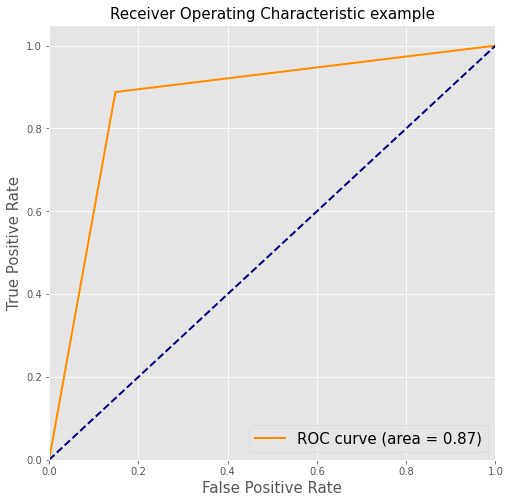

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

true_labels = label_binarize(true_labels, classes=[0, 1])
n_classes = true_labels.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(true_labels[:], predictions[:])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=15)
plt.ylabel('True Positive Rate',fontsize=15)
plt.title('Receiver Operating Characteristic example', fontsize=15)
plt.legend(loc="lower right",fontsize=15)
plt.show()